# Vehicle Steering with DenseNet Architecture
In this notebook, we will talk through training vechicle steering with Udacity data with a newly proposed architecture called DenseNet

In [1]:
import pandas as pd
import os, sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import steering_img_util
from keras.models import load_model

Using TensorFlow backend.


# Loading the dataset
thanks to the Udacity open course dataset, we can train a preliminary model with the data 

In [2]:
os.chdir("/home/ubuntu/dataset/udacity-driving")

In [3]:
steering_labels = pd.read_csv("interpolated.csv")
print(steering_labels.shape)
steering_labels.head()

(45636, 12)


,index,timestamp,width,height,frame_id,filename,angle,torque,speed,lat,long,alt
0,2016-09-29 22:09:25.602401049,1475186965602401049,640,480,left_camera,left/1475186965602401049.jpg,-0.045649,-0.644359,14.605986,0.0,0.0,0.0
1,2016-09-29 22:09:25.609972775,1475186965609972775,640,480,center_camera,center/1475186965609972775.jpg,-0.046314,-0.691983,14.607044,0.0,0.0,0.0
2,2016-09-29 22:09:25.630938502,1475186965630938502,640,480,right_camera,right/1475186965630938502.jpg,-0.047124,-0.677232,14.611567,0.0,0.0,0.0
3,2016-09-29 22:09:25.652132892,1475186965652132892,640,480,left_camera,left/1475186965652132892.jpg,-0.047124,-0.585284,14.615654,0.0,0.0,0.0
4,2016-09-29 22:09:25.659735933,1475186965659735933,640,480,center_camera,center/1475186965659735933.jpg,-0.047099,-0.560746,14.616667,0.0,0.0,0.0


# Building a DenseNet

In [4]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import AveragePooling2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model, convert_dense_weights_data_format
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import plot_model
from keras.optimizers import Adam
import keras.backend as K

In [5]:
def DenseNet(input_shape=None, depth=10, nb_dense_block=3, growth_rate=12, nb_filter=-1, nb_layers_per_block=-1,
             bottleneck=False, reduction=0.0, dropout_rate=0.0, weight_decay=1e-4, subsample_initial_block=False,
             include_top=True, weights=None, input_tensor=None,
             classes=1):
    ''' # Arguments
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(32, 32, 3)` (with `channels_last` dim ordering)
                or `(3, 32, 32)` (with `channels_first` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            depth: number or layers in the DenseNet
            nb_dense_block: number of dense blocks to add to end (generally = 3)
            growth_rate: number of filters to add per dense block
            nb_filter: initial number of filters. -1 indicates initial
                number of filters is 2 * growth_rate
            nb_layers_per_block: number of layers in each dense block.
                Can be a -1, positive integer or a list.
                If -1, calculates nb_layer_per_block from the network depth.
                If positive integer, a set number of layers per dense block.
                If list, nb_layer is used as provided. Note that list size must
                be (nb_dense_block + 1)
            bottleneck: flag to add bottleneck blocks in between dense blocks
            reduction: reduction factor of transition blocks.
                Note : reduction value is inverted to compute compression.
            dropout_rate: dropout rate
            weight_decay: weight decay rate
            subsample_initial_block: Set to True to subsample the initial convolution and
                add a MaxPool2D before the dense blocks are added.
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: one of `None` (random initialization) or
                'imagenet' (pre-training on ImageNet)..
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        '''

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_dense_net(classes, img_input, include_top, depth, nb_dense_block,
                           growth_rate, nb_filter, nb_layers_per_block, bottleneck, reduction,
                           dropout_rate, weight_decay, subsample_initial_block)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    print(inputs)
    model = Model(inputs, x, name='densenet')

    return model



def __conv_block(ip, nb_filter, bottleneck=False, dropout_rate=None, weight_decay=1e-4):
    ''' Apply BatchNorm, Relu, 3x3 Conv2D, optional bottleneck block and dropout
    Args:
        ip: Input keras tensor
        nb_filter: number of filters
        bottleneck: add bottleneck block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
    Returns: keras tensor with batch_norm, relu and convolution2d added (optional bottleneck)
    '''
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(ip)
    x = Activation('relu')(x)

    if bottleneck:
        inter_channel = nb_filter * 4  # Obtained from https://github.com/liuzhuang13/DenseNet/blob/master/densenet.lua

        x = Conv2D(inter_channel, (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
                   kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
        x = Activation('relu')(x)

    x = Conv2D(nb_filter, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def __dense_block(x, nb_layers, nb_filter, growth_rate, bottleneck=False, dropout_rate=None, weight_decay=1e-4,
                  grow_nb_filters=True, return_concat_list=False):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
    Args:
        x: keras tensor
        nb_layers: the number of layers of conv_block to append to the model.
        nb_filter: number of filters
        growth_rate: growth rate
        bottleneck: bottleneck block
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        grow_nb_filters: flag to decide to allow number of filters to grow
        return_concat_list: return the list of feature maps along with the actual output
    Returns: keras tensor with nb_layers of conv_block appended
    '''
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x_list = [x]

    for i in range(nb_layers):
        cb = __conv_block(x, growth_rate, bottleneck, dropout_rate, weight_decay)
        x_list.append(cb)

        x = concatenate([x, cb], axis=concat_axis)

        if grow_nb_filters:
            nb_filter += growth_rate

    if return_concat_list:
        return x, nb_filter, x_list
    else:
        return x, nb_filter


def __transition_block(ip, nb_filter, compression=1.0, weight_decay=1e-4):
    ''' Apply BatchNorm, Relu 1x1, Conv2D, optional compression, dropout and Maxpooling2D
    Args:
        ip: keras tensor
        nb_filter: number of filters
        compression: calculated as 1 - reduction. Reduces the number of feature maps
                    in the transition block.
        dropout_rate: dropout rate
        weight_decay: weight decay factor
    Returns: keras tensor, after applying batch_norm, relu-conv, dropout, maxpool
    '''
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(ip)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_filter * compression), (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
               kernel_regularizer=l2(weight_decay))(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x

def __create_dense_net(nb_classes, img_input, include_top, depth=10, nb_dense_block=3, growth_rate=12, nb_filter=-1,
                       nb_layers_per_block=-1, bottleneck=False, reduction=0.0, dropout_rate=None, weight_decay=1e-4,
                       subsample_initial_block=False):
    ''' Build the DenseNet model
    Args:
        nb_classes: number of classes
        img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
        include_top: flag to include the final Dense layer
        depth: number or layers
        nb_dense_block: number of dense blocks to add to end (generally = 3)
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters. Default -1 indicates initial number of filters is 2 * growth_rate
        nb_layers_per_block: number of layers in each dense block.
                Can be a -1, positive integer or a list.
                If -1, calculates nb_layer_per_block from the depth of the network.
                If positive integer, a set number of layers per dense block.
                If list, nb_layer is used as provided. Note that list size must
                be (nb_dense_block + 1)
        bottleneck: add bottleneck blocks
        reduction: reduction factor of transition blocks. Note : reduction value is inverted to compute compression
        dropout_rate: dropout rate
        weight_decay: weight decay rate
        subsample_initial_block: Set to True to subsample the initial convolution and
                add a MaxPool2D before the dense blocks are added.
        subsample_initial:
    Returns: keras tensor with nb_layers of conv_block appended
    '''

    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    if reduction != 0.0:
        assert reduction <= 1.0 and reduction > 0.0, 'reduction value must lie between 0.0 and 1.0'

    # layers in each dense block
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)  # Convert tuple to list

        assert len(nb_layers) == (nb_dense_block), 'If list, nb_layer is used as provided. ' \
                                                   'Note that list size must be (nb_dense_block)'
        final_nb_layer = nb_layers[-1]
        nb_layers = nb_layers[:-1]
    else:
        if nb_layers_per_block == -1:
            assert (depth - 4) % 3 == 0, 'Depth must be 3 N + 4 if nb_layers_per_block == -1'
            count = int((depth - 4) / 3)
            nb_layers = [count for _ in range(nb_dense_block)]
            final_nb_layer = count
        else:
            final_nb_layer = nb_layers_per_block
            nb_layers = [nb_layers_per_block] * nb_dense_block

    # compute initial nb_filter if -1, else accept users initial nb_filter
    if nb_filter <= 0:
        nb_filter = 2 * growth_rate

    # compute compression factor
    compression = 1.0 - reduction

    # Initial convolution
    if subsample_initial_block:
        initial_kernel = (7, 7)
        initial_strides = (2, 2)
    else:
        initial_kernel = (3, 3)
        initial_strides = (1, 1)

    x = Conv2D(nb_filter, initial_kernel, kernel_initializer='he_normal', padding='same',
               strides=initial_strides, use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)

    if subsample_initial_block:
        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        x, nb_filter = __dense_block(x, nb_layers[block_idx], nb_filter, growth_rate, bottleneck=bottleneck,
                                     dropout_rate=dropout_rate, weight_decay=weight_decay)
        # add transition_block
        x = __transition_block(x, nb_filter, compression=compression, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    # The last dense_block does not have a transition_block
    x, nb_filter = __dense_block(x, final_nb_layer, nb_filter, growth_rate, bottleneck=bottleneck,
                                 dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)

    if include_top:
        x = Dense(nb_classes)(x)

    return x

In [6]:
model = DenseNet((480, 640, 3), weights=None)
model.summary()

Tensor("input_1:0", shape=(?, 480, 640, 3), dtype=float32)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 480, 640, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 480, 640, 24)  648         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 480, 640, 24)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 480, 640, 24)  0           batch_normalization_1[0][0]      
________________________________

In [7]:
def generate_train_batch(data, batch_size = 16):

    img_rows = 480
    img_cols = 640
    
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    angles = np.zeros((batch_size, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(2000)
            i_line = i_line+len(data)-2000
            
            file_name = steering_labels.iloc[i_line]["filename"]
            img = cv2.imread(file_name)
            f =  float(float(steering_labels.iloc[i_line]["angle"])* 180.00 / 3.14159265359 )
    
            batch_images[i_batch] = img
            angles[i_batch] = f
        yield batch_images, angles

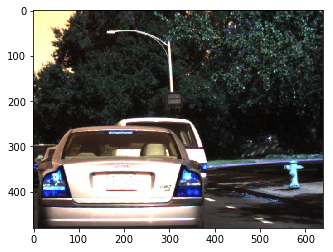

[ 14.20182482]


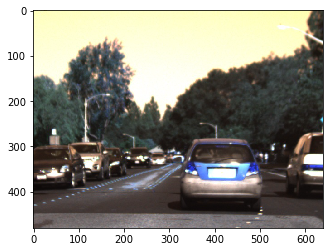

[ 2.89999992]


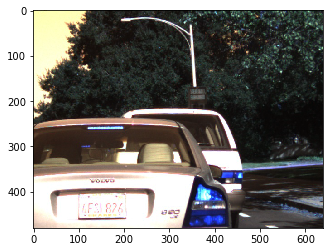

[ 11.3999998]


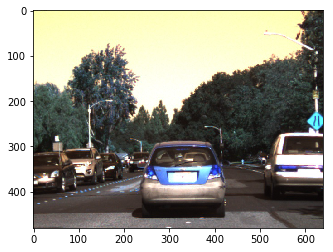

[ 2.93166844]


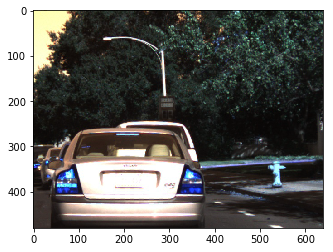

[ 10.40000035]


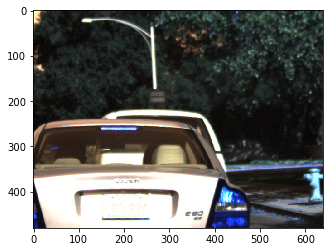

[ 11.3999998]


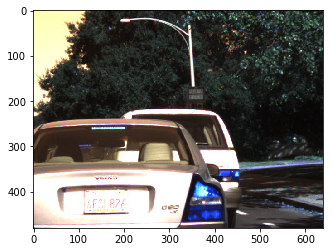

[ 11.49999975]


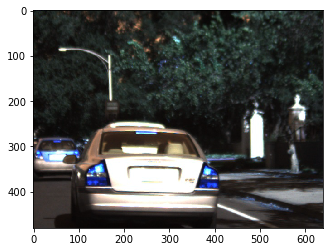

[ 4.41251453]


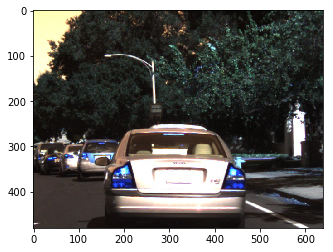

[ 3.60000019]


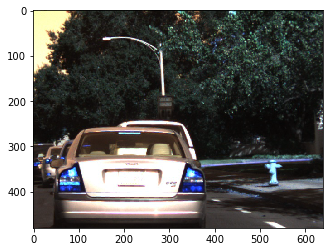

[ 9.45950853]


In [8]:
# testing the generator
training_gen = generate_train_batch(steering_labels, 10)
batch_img, steering_angle = next(training_gen)

for i in range(10):
    im = np.array(batch_img[i], dtype=np.uint8)
    steering = steering_angle[i]
    plt.imshow(im)
    plt.show();
    print(steering)

In [20]:
# os.chdir("/home/ubuntu/")
# model = load_model("my_model.h5")
optimizer = Adam(lr=1e-3) # Using Adam instead of SGD to speed up training
model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'acc'])

In [21]:
# os.chdir("/home/ubuntu/")
# model = load_model("my_model.h5")

In [22]:
training_gen = generate_train_batch(steering_labels, 1)
history = model.fit_generator(training_gen, steps_per_epoch=3000, epochs=1, verbose=1)

Epoch 1/1
  65/3000 [..............................] - ETA: 1137s - loss: 24.9127 - mean_squared_error: 24.8900 - acc: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
os.chdir("/home/ubuntu/")
model.save('my_model.h5') 

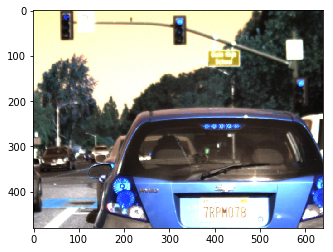

[ 0.99999999]
[ 3.13980937]


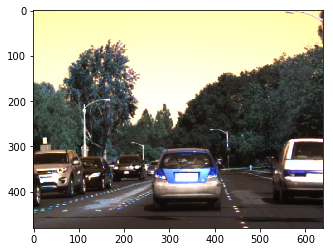

[ 3.40000008]
[ 3.73757124]


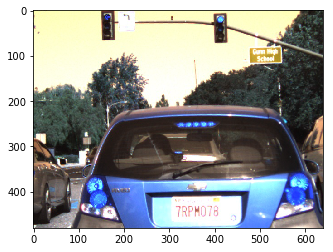

[ 0.99999999]
[ 3.8811152]


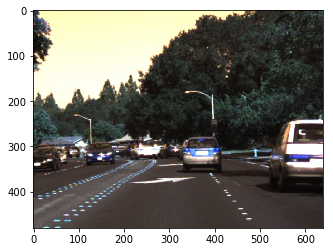

[-2.51808513]
[ 2.79605699]


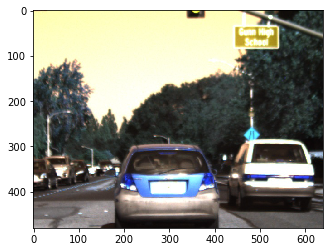

[ 0.9218952]
[ 3.21402311]


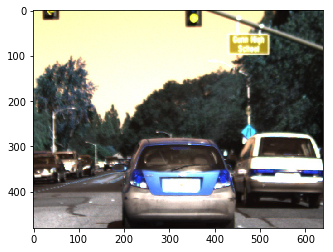

[ 0.]
[ 3.15274739]


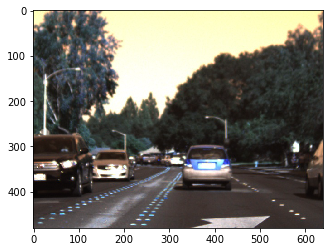

[-0.4]
[ 3.31801057]


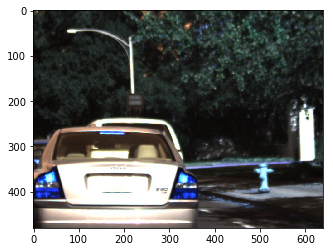

[ 14.40000074]
[ 1.2756598]


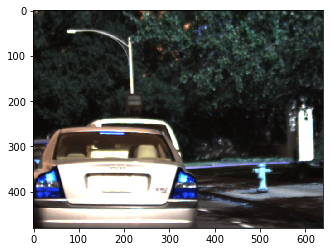

[ 14.29999994]
[ 1.2510767]


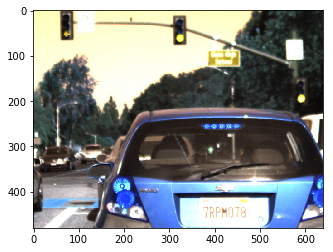

[ 0.99999999]
[ 3.25563073]


In [13]:
# testing the results
training_gen = generate_train_batch(steering_labels, 10)
imgs, angels = next(training_gen)
predictions = model.predict(imgs)

for i in range(10):
    im = np.array(imgs[i], dtype=np.uint8)
    plt.imshow(im)
    plt.show();
    print(angels[i])
    print(predictions[i])

# Play around with some other stuff

In [ ]:
inputs = Input((480, 640, 3))
batch_norm = BatchNormalization(epsilon=0.001, axis=1,input_shape=(480,680, 3))(inputs)

conv1 = Conv2D(24, (5,5), padding='valid', activation='relu', strides=(2,2))(batch_norm)
conv3 = Conv2D(24, (5,5), padding='valid', activation='relu', strides=(2,2))(conv1)
conv4 = Conv2D(48, (3,3), padding='valid', activation='relu', strides=(1,1))(conv3)
conv5 = Conv2D(48, (3,3), padding='valid', activation='relu', strides=(1,1))(conv4)
flatten = Flatten()(conv5)
dense1 = Dense(800, activation='relu')(flatten)
dense3 = Dense(100, activation='relu')(dense1)
dense4 = Dense(10, activation='relu')(dense3)
dense5 = Dense(1, activation='tanh')(dense4)

model = Model(input=inputs, output=dense5)

model.summary()

In [ ]:
optimizer = Adam(lr=1e-3) # Using Adam instead of SGD to speed up training
model.compile(loss='mse', optimizer=optimizer, metrics=['mse','accuracy'])

In [ ]:
training_gen = generate_train_batch(steering_labels, 1000)
batch_img, steering_angle = next(training_gen)

In [ ]:
model.fit(batch_img, steering_angle, batch_size=32, epochs=10, verbose=1, callbacks=None, class_weight=None, sample_weight=None, initial_epoch=0)

In [ ]:
training_gen = generate_train_batch(steering_labels, 1)
history = model.fit_generator(training_gen, steps_per_epoch=3000, epochs=1, verbose=1)

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
# testing the dense implementation with MNIST
batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = DenseNet(input_shape=(28, 28, 1), weights=None, classes=10)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
print(model.summary)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))